In [1]:
import os
import functools
import contextlib
from pathlib import Path
from urllib import request
import time

import numpy as onp

import jax
import optax
from jax import numpy as jnp, random, tree_util

from jax_md_mod import io, custom_quantity, custom_space
from jax_md_mod.model import layers, neural_networks, prior
from jax_md import simulate, partition, space

import mdtraj

import matplotlib.pyplot as plt

import haiku as hk

from chemtrain.data import preprocessing
from chemtrain.ensemble import sampling
from chemtrain import quantity, trainers, util

out_dir = Path("../_data/output")
out_dir.mkdir(exist_ok=True)

2024-08-05 12:47:24.999719: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Alanine Dipeptide in Implicit Water

This example reproduces the results of the paper [Deep Coarse-Grained Potentials via Relative Entropy Minimization](https://doi.org/10.1063/5.0124538) [^Thaler2022].

This paper introduces the bottom-up coarse-graining approach of Relative Entropy Minimization (REM) to Neural Network (NN) potential models.
In the example of alanine-dipeptide in implicit water, the paper compares REM to the conventional Force Matching (FM) scheme.

We outline the theoretical backgrounds of the REM and FM schemes in the toy examples to [Relative Entropy Minimization](../algorithms/relative_entropy.md) and [Force Matching](../algorithms/force_matching.md).
We refer to the original paper for a more detailed analysis of the connection between those approaches.

## Problem

Alanine dipeptide is a good test case for developing coarse-grained protein models.
Torsional potentials derived from alanine dipeptide generalize well to larger amino acids [^Feig2008]. 
Thus, this example compares two algorithms for learning Graph Neural Network (GNN) potentials based on representing the torsional preferences of alanine dipeptide.

```{figure} ../_static/alanine_heavy.png
:name: Alanine Dipeptide

Alanine Dipeptide
```

The coarse-grained model of alanine dipeptide only preserves the heavy atoms $\mathrm C$, $\mathrm N$, and $\mathrm O$ but distinguishes between carbon with different environments.
Therefore, the coarse-grained model contains the five species $\mathrm{CH_3}, \mathrm{CH}, \mathrm{C}, \mathrm{O}, \mathrm{N}$.
Additionally, the GNN does not explicitly consider water and should thus implicitly include the interactions with the solvent.

In [3]:
# Set random key and thermodynamic statepoint (300 K)
key = random.PRNGKey(21)
kT = 300. * quantity.kb
state_kwargs = {'kT': kT}

Before defining the potential model, we set up the space in which it acts.
Therefore, we load an initial conformation, define a corresponding periodic space, and construct a neighbor list with a cutoff radius of $0.5~\text{nm}$.

In [4]:
# To construct a NN model, we first need to create a neighborlist.
# The neighborlist is necessary to construct a graph containing the environment
# of each atom.
box, r_init, _, _ = io.load_box("../_data/alanine_heavy_2_7nm.gro")

n_species = 5
r_cut = 0.5

fractional = True

displacement_fn, shift_fn = space.periodic_general(
    box, fractional_coordinates=fractional)

if fractional:
    box_tensor, scale_fn = custom_space.init_fractional_coordinates(box)
    r_init = scale_fn(r_init)
else:
    box_tensor = box

neighbor_fn = partition.neighbor_list(
    displacement_fn, box_tensor, r_cut, disable_cell_list=True,
    fractional_coordinates=fractional, capacity_multiplier=1.5
)

nbrs_init = neighbor_fn.allocate(r_init, extra_capacity=1)

To improve the stability of the learned potential, we employ a $\Delta$--learning
approach.
As a prior, we use commonly used intra-molecular potentials and repulsive
non-bonded terms

```{math}
U^\text{prior}(\mathbf R) = \sum_{(i,j) \in \mathcal B} U_b(|\mathbf r_i - \mathbf r_j|) + \sum_{(i,j,k) \in \mathcal A}U_\alpha(\alpha(\mathbf r_i, \mathbf r_j, \mathbf r_k)) \\ + \sum_{(i,j,k,l) \in \mathcal D}U_\phi(\phi(\mathbf r_j - \mathbf r_i,  \mathbf r_l - \mathbf r_k)) + \sum_{(i,j) \notin\mathcal B,\mathcal A, \mathcal D } U_r(|\mathbf r_i - \mathbf r_j|),
```

where $\mathcal B, \mathcal A, \mathcal D$ are the indices of the atoms that form bonds, angles, and dihedral angles, respectively.
Note also that atoms do not interact via the nonbonded term if involved in the same bond, angle, or dihedral angle.
For the bonds and angles, we choose a harmonic potential
$$
U_b(x) = \frac{k}{2}(x - x_0)^2,
$$
where we derived the parameters $k$ and $x_0$ for each combination of species from the mean and variance of $x$
$$
x_0 = \langle x \rangle_\text{AT}, \quad k = \frac{1}{2\beta\langle(x - x_0)^2\rangle_\text{AT}}.
$$
For the dihedral angles, we choose a cosine series up to third order
$$
U_\phi(\phi) = \sum_{n=1}^3 k_{\phi, i} (1 + \cos(n\phi - \phi_{0, i})).
$$
where we took the values for the force constants $k_{\phi, i}$ and phase shifts $\phi_{0, i}$ from the Amber03 force field [^Duan2003]. 
The non-bonded repulsion has the form
$$
U_r(x) = \varepsilon\left(\frac{x}{\sigma}\right)^{12}.
$$
We computed the pairwise parameters $\varepsilon_{ij} = \sqrt{\varepsilon_{ii}\varepsilon_{jj}}$ and $\sigma_{ij} = \frac{\sigma_{ii} + \sigma_{jj}}{2}$ via the Lorentz-Berthelot combining rules [^Tildesley2017] from the Amber03 parameters.


We now construct this prior potential in **chemtrain**.
First, we select the corresponding potential terms, i.e., harmonic bond and angle terms, cosine dihedral angle terms, and repulsive nonbonded terms in the correct space.

In [5]:
prior_energy = prior.init_prior_potential(displacement_fn, nonbonded_type="repulsion")

Following, we load the potential parameters.

In [6]:
with open("../_data/alanine_heavy.toml") as f:
    print(f.read())
    
force_field = prior.ForceField.load_ff("../_data/alanine_heavy.toml")

[bonded]
bondtypes = """
#    i,    j,    b0,    kb
    C,  CH3,0.15172,271037.3
    C,    O,0.12325,476729.7
    C,    N,0.13359,416066.4
    C,   CA,0.15445,277737.0
   CA,  CH3,0.15370,268630.6
   CA,    N,0.14683,290439.9
  CH3,    N,0.14592,287462.0
"""
angletypes = """
#    i,    j,    k,    th0,    kth
  CH3,    C,    O,119.896,  0.319
  CH3,    C,    N,116.911,  0.305
    N,    C,    O,122.485,  0.338
    C,    N,   CA,124.654,  0.247
  CH3,   CA,    N,108.107,  0.260
    C,   CA,    N,113.044,  0.231
    C,   CA,  CH3,111.665,  0.230
   CA,    C,    O,120.259,  0.320
   CA,    C,    N,117.381,  0.301
    C,    N,  CH3,124.797,  0.245
"""
dihedraltypes = """
#    i,    j,    k,    l,    phase,    kd    pn
    C,    N,   CA,    C,   0.00,  4.251,   1
    C,    N,   CA,    C, 180.00,  1.444,   2
    C,    N,   CA,    C,   0.00,  0.945,   3
    N,   CA,    C,    N, 180.00,  2.861,   1
    N,   CA,    C,    N, 180.00,  6.082,   2
    N,   CA,    C,    N, 180.00,  1.931,   3
   CA, 

Finally, we must define the index sets for the bonds $\mathcal B$, angles $\mathcal A$, and dihedral angles $\mathcal D$.
Luckily, we do not have to gather the correct indices by hand.
Instead, **chemtrain** allows automatically identifying these indices by traversing a molecular graph, e.g., constructed from the **mdtraj** package [^McGibbon2015].

In [7]:
top = mdtraj.load_topology("../_data/alanine_heavy_2_7nm.gro")

_mapping = force_field.mapping(by_name=True)
def mapping(name="", residue="", **kwargs):
    if residue == "NME" and name =="C":
        return _mapping(name="CH3", **kwargs)
    if name == "CB":
        return _mapping(name="CH3", **kwargs)
    else:
        return _mapping(name=name, **kwargs)

topology = prior.Topology.from_mdtraj(top, mapping)

species = topology.get_atom_species()
masses, *_ = force_field.get_nonbonded_params(species)[0].T

/home/paul/chemtrain/jax_md_mod/model/prior.py:526: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  improper_dihedral_idx = jnp.zeros((0, 4), dtype=jnp.int_)


## Model definition

With the prior potential defined, we can now construct the learnable difference $\Delta U_\theta$.
We select the DimeNet++ graph neural network architecture [^DimeNet], shipped with **chemtrain**.

In [8]:
# We need an example graph (neighbor list) to determine the number
# of nodes, edges, angles, etc.

mlp_init = {
    'b_init': hk.initializers.Constant(0.),
    'w_init': layers.OrthogonalVarianceScalingInit(scale=1.)
}


init_fn, gnn_energy_fn = neural_networks.dimenetpp_neighborlist(
    displacement_fn, r_cut, n_species, r_init, nbrs_init,
    embed_size=32, init_kwargs=mlp_init,
)


# Create the parametrizable energy function and an initial
# parametrization
key, split = random.split(key)
init_params = init_fn(
    split, r_init, neighbor=nbrs_init, species=species
)

def energy_fn_template(energy_params):
    
    prior_energy_fn = prior_energy(topology, force_field)
    
    def energy_fn(pos, neighbor, **dynamic_kwargs):
        gnn_energy = gnn_energy_fn(
            energy_params, pos, neighbor, species=species,
            **dynamic_kwargs
        )

        prior_energy = prior_energy_fn(pos, neighbor=neighbor)
        return gnn_energy + prior_energy
    return energy_fn

Capping edges and triplets. Beware of overflow, which is currently not being detected.


Estimated max. 90 edges and max. 683 triplets.


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explic

## Reference Data

We use the reference data from the original paper [^Thaler2022].
This reference data consists of $5\times10^{5}$ conformations with corresponding forces, subsampled every $200~\text{fs}$ from a $100~\text{ns}$ all-atomistic simulation of alanine-dipeptide in TIP3P water.

In [9]:
# Download if not present
position_url = "https://drive.usercontent.google.com/download?id=1yKVHiI8y7ZNzyduh8bosR6YKScLyFezU&export=download&confirm=t&uuid=cff71a05-a45a-446e-bf2f-17f62e84263f"
force_url = "https://drive.usercontent.google.com/download?id=1JhRQcZ3tE2w-mLqTGN0JHJQst5uZijJx&export=download&confirm=t&uuid=ad4f279f-18b7-4b65-a144-ab1115110549" 

forces_path = "../_data/forces_heavy_100ns.npy"
positions_path = "../_data/positions_heavy_100ns.npy"

if not Path(forces_path).exists():
    request.urlretrieve(force_url, forces_path)
if not Path(positions_path).exists():
    request.urlretrieve(position_url, positions_path)

force_dataset = preprocessing.get_dataset(forces_path)
position_dataset = preprocessing.get_dataset(positions_path)

if fractional:
    position_dataset = preprocessing.scale_dataset_fractional(
        position_dataset, box
    )

## Simulation

As outlined in the [Relative Entropy example](../algorithms/relative_entropy),
estimating the gradients of the relative entropy requires samples from the current coarse-grained ensemble.
Moreover, we want to compare the learned models in predicting the distributions of backbone dihedral angles.
Thus, we need to simulate CG alanine dipeptide based on the neural network and prior potential.
However, we do not set up a single long simulation.
Instead, we set up $100$ parallel and shorter simulations to accelerate the sampling.
These simulations start from conformations randomly selected from the reference data without replacement.

In [10]:
dt = 0.002
n_chains = 100
gamma = 100.

key, split = random.split(key)
selection = random.choice(
    split, jnp.arange(position_dataset.shape[0]), shape=(n_chains,), replace=False)
r_init = position_dataset[selection, ...]

init_ref_state, sim_template = sampling.initialize_simulator_template(
    simulate.nvt_langevin, shift_fn=shift_fn, nbrs=nbrs_init,
    init_with_PRNGKey=True, extra_simulator_kwargs={"kT": kT, "gamma": gamma, "dt": dt}
)

key, split = random.split(key)
reference_state = init_ref_state(
    split, r_init,
    energy_or_force_fn=energy_fn_template(init_params),
    init_sim_kwargs={"mass": masses, "neighbor": nbrs_init}
)

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packag

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


## Relative Entropy Minimization

With reference data, potential model, and simulation routine set up, we can now instantiate the REM algorithm.
We only use a subset of $80~\%$ of the data for training.
We also set the reweighting ratio to issue a new trajectory after every update.
Nevertheless, we tune the step size such that at least $25~\%$ effective samples remain after each update.

In [11]:
re_initial_lr = 0.003
re_epochs = 300
re_used_dataset_size = 400000

t_sample = 0.5
total_time = 110.
t_eq = 10.

re_timings = sampling.process_printouts(
    time_step=dt, total_time=total_time,
    t_equilib=t_eq, print_every=t_sample
)

lr_schedule = optax.exponential_decay(re_initial_lr, re_epochs, 0.01)
optimizer = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_schedule(lr_schedule),
    optax.scale_by_learning_rate(1.0)
)

relative_entropy = trainers.RelativeEntropy(
    init_params, optimizer, reweight_ratio=1.1,
    energy_fn_template=energy_fn_template)

relative_entropy.add_statepoint(
    position_dataset[:re_used_dataset_size, ...],
    energy_fn_template, sim_template, neighbor_fn,
    re_timings, state_kwargs, reference_state,
    reference_batch_size=re_used_dataset_size // 10,
    vmap_batch=n_chains, resample_simstates=True)

relative_entropy.init_step_size_adaption(0.25)

/home/paul/chemtrain/chemtrain/ensemble/reweighting.py:777: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explic

Time for trajectory initialization 0: 2.5893545826276143 mins
[Step size] Use 7 iterations for 10 interior points.


In [12]:
if os.environ.get("RM_TRAINING", "False").lower() == "true":
    # Save the training log
    with open("../_data/output/alanine_dipeptide_rm_training.log", "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            start = time.time()
            relative_entropy.train(300)
            print(f"Total training time: {(time.time() - start) / 3600 : .1f} hours")
    
    relative_entropy.save_energy_params("../_data/output/alanine_dipeptide_re_params.pkl", '.pkl')
    relative_entropy.save_trainer("../_data/output/alanine_dipeptide_re_trainer.pkl", '.pkl')

relative_entropy = onp.load("../_data/output/alanine_dipeptide_re_trainer.pkl", allow_pickle=True)
relative_entropy_params = tree_util.tree_map(
    jnp.asarray, onp.load("../_data/output/alanine_dipeptide_re_params.pkl", allow_pickle=True)
)

with open("../_data/output/alanine_dipeptide_rm_training.log") as f:
    print(f.read())

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
[Step Size] Found optimal step size 1.0 with residual 0.5133256912231445

[RE] Epoch 0
	Mean Delta RE loss = 15.55159
	Gradient norm: 96.93727111816406
	Elapsed time = 4.626 min
[Statepoint 0]
	kT = 2.437 ref_kT = 2.494
[Step Size] Found optimal step size 0.4760661721229553 with residual 2.002716064453125e-05

[RE] Epoch 1
	Mean Delta RE loss = 1.08074
	Gradient norm: 137.0275115966797
	Elapsed time = 2.807 min
[Statepoint 0]
	kT = 2.445 ref_kT = 2.494
[Step Size] Found optimal step size 0.6170003414154053 with residual 4.76837158203125e-06

[RE] Epoch 

Plotting the change of relative entropy and the gradient norm indicates convergence of the algorithm for $300$ epochs.

Text(0, 0.5, 'Gradient Norm')

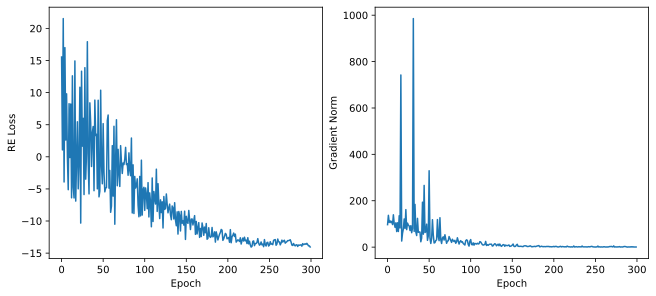

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")

ax1.plot(relative_entropy["delta_re"][0])
ax1.set_xticks(ticks=range(0, re_epochs + 1, 50))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("RE Loss")

ax2.plot(relative_entropy["gradient_norm_history"])
ax2.set_xticks(ticks=range(0, re_epochs + 1, 50))
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Gradient Norm")

## Force Matching

As a reference, we train an instance of the potential model via FM.
Similar to REM, we only consider a subset of the data for training.
However, mainly to prevent overfitting, we need additional data for validation.
Hence, the part of data we can use for training is smaller.

In [14]:
fm_epochs = 100
fm_used_dataset_size = 500000
fm_train_ratio = 0.7
fm_val_ratio = 0.1
fm_batch_per_device = 500 // len(jax.devices())
fm_batch_cache = 50
fm_initial_lr = 0.0003

lrd = int(fm_used_dataset_size / fm_batch_per_device / len(jax.devices()) * fm_epochs)
lr_schedule = optax.exponential_decay(fm_initial_lr, lrd, 0.01)
fm_optimizer = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_schedule(lr_schedule),
    optax.scale_by_learning_rate(1.0)
)

force_matching = trainers.ForceMatching(
    init_params, fm_optimizer, energy_fn_template, nbrs_init,
    batch_per_device=fm_batch_per_device,
    batch_cache=fm_batch_cache,
)

force_matching.set_datasets({
    'R': position_dataset[:fm_used_dataset_size, ...], 
    'F': force_dataset[:fm_used_dataset_size, ...]
}, train_ratio=fm_train_ratio 
)

In [15]:
if os.environ.get("FM_TRAINING", "False").lower() == "true":
    # Save the training log
    with open("../_data/output/alanine_dipeptide_fm_training.log", "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            
            print(f"Visible devices: {jax.devices()}")
            
            start = time.time()
            force_matching.train(fm_epochs)
            print(f"Total training time: {(time.time() - start) / 3600 : .1f} hours")
    
    force_matching.save_energy_params("../_data/output/alanine_dipeptide_fm_params.pkl", '.pkl')
    force_matching.save_trainer("../_data/output/alanine_dipeptide_fm_trainer.pkl", '.pkl')
    
force_matching = onp.load("../_data/output/alanine_dipeptide_fm_trainer.pkl", allow_pickle=True)
force_matching_params = tree_util.tree_map(
    jnp.asarray, onp.load("../_data/output/alanine_dipeptide_fm_params.pkl", allow_pickle=True)
)

with open("../_data/output/alanine_dipeptide_fm_training.log") as f:
    print(f.read())

Visible devices: [cuda(id=0)]
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_num

Plotting the training and validation loss indicates convergence after approximately $50$ epochs.
Further training improves the validation loss only slightly, but does not lead to overfitting.
Therefore, we save the final model with $100$ training epochs.

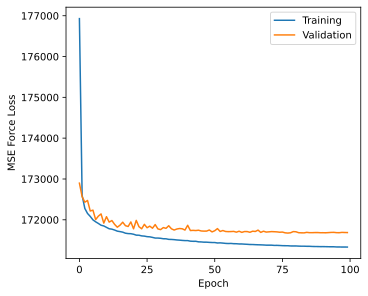

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout="constrained")
ax.plot(force_matching["train_losses"], label="Training")
ax.plot(force_matching["val_losses"], label="Validation")
ax.set_xticks(ticks=range(0, fm_epochs + 1, 25))
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Force Loss")
ax.legend()

## Force Matching and Relative Entropy Minimization

Due to the expense of training with relative entropy minimization,
we train a third model from an improved initial state.
As improved initial state, we use the FM trained model with the lowest validation
loss.

In [17]:
rm_post_epochs = 50
rm_post_initial_lr = 0.0005

lr_schedule = optax.exponential_decay(rm_post_initial_lr, rm_post_epochs, 0.01)
optimizer = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_schedule(lr_schedule),
    optax.scale_by_learning_rate(1.0)
)

rm_post_fm = trainers.RelativeEntropy(
    force_matching_params, optimizer, reweight_ratio=1.1,
    energy_fn_template=energy_fn_template)

rm_post_fm.add_statepoint(
    position_dataset[:re_used_dataset_size, ...],
    energy_fn_template, sim_template, neighbor_fn,
    re_timings, state_kwargs, reference_state,
    reference_batch_size=re_used_dataset_size,
    vmap_batch=n_chains, resample_simstates=True)

rm_post_fm.init_step_size_adaption(0.25)

/home/paul/chemtrain/chemtrain/ensemble/reweighting.py:777: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explic

Time for trajectory initialization 0: 2.5934632341066997 mins
[Step size] Use 7 iterations for 10 interior points.


In [18]:
if os.environ.get("FM_RM_TRAINING", "False").lower() == "true":
    # Save the training log
    with open("../_data/output/alanine_dipeptide_fm+rm_training.log", "w") as f:
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):

            start = time.time()
            rm_post_fm.train(rm_post_epochs)
            print(f"Total training time: {(time.time() - start) / 3600 : .1f} hours")
    
    rm_post_fm.save_energy_params("../_data/output/alanine_dipeptide_fm+rm_params.pkl", '.pkl')
    rm_post_fm.save_trainer("../_data/output/alanine_dipeptide_fm+rm_trainer.pkl", '.pkl')
    
rm_post_fm = onp.load("../_data/output/alanine_dipeptide_fm+rm_trainer.pkl", allow_pickle=True)
rm_post_fm_params = tree_util.tree_map(
    jnp.asarray, onp.load("../_data/output/alanine_dipeptide_fm+rm_params.pkl", allow_pickle=True)
)

with open("../_data/output/alanine_dipeptide_fm+rm_training.log") as f:
    print(f.read())

/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
[Step Size] Found optimal step size 1.0 with residual 0.7586336135864258

[RE] Epoch 0
	Mean Delta RE loss = 35.93504
	Gradient norm: 134.17303466796875
	Elapsed time = 4.854 min
[Statepoint 0]
	kT = 2.435 ref_kT = 2.494
[Step Size] Found optimal step size 1.0 with residual 1.2179021835327148

[RE] Epoch 1
	Mean Delta RE loss = 28.64944
	Gradient norm: 26.833358764648438
	Elapsed time = 3.084 min
[Statepoint 0]
	kT = 2.444 ref_kT = 2.494
[Step Size] Found optimal step size 1.0 with residual 1.1800079345703125

[RE] Epoch 2
	Mean Delta RE loss = 30.60202

Text(0, 0.5, 'Gradient Norm')

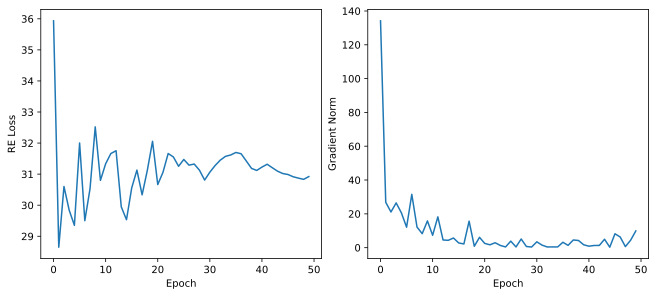

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")

ax1.plot(rm_post_fm["delta_re"][0])
ax1.set_xticks(ticks=range(0, rm_post_epochs + 1, 10))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("RE Loss")

ax2.plot(rm_post_fm["gradient_norm_history"])
ax2.set_xticks(ticks=range(0, rm_post_epochs + 1, 10))
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Gradient Norm")

## Evaluation

With both trained models, we perform a series of simulations to evaluate the alignment of both models with the reference data.
To reduce the total running time, we again run $100$ shorter simulations, which
still correspond to a total time of $100~\text{ns}$.

In [20]:
eval_total_time = 2100.
eval_t_eq = 100.
eval_t_sample = .5

eval_timings = sampling.process_printouts(
    time_step=dt, total_time=eval_total_time,
    t_equilib=eval_t_eq, print_every=eval_t_sample
)

trajectory_generator = sampling.trajectory_generator_init(
    sim_template, energy_fn_template, eval_timings)
trajectory_generator = jax.vmap(
    functools.partial(trajectory_generator, **state_kwargs), (0, None)
)

In [21]:
if os.environ.get("EVALUATION", "False").lower() == "true":
 
    all_parameters = util.tree_stack((
        relative_entropy_params,
        force_matching_params,
        rm_post_fm_params
    ))
    
    t_start = time.time()
    all_traj_states = trajectory_generator(all_parameters, reference_state)
    
    assert not jnp.any(all_traj_states.overflow), (
        'Neighborlist overflow during trajectory generation. '
        'Increase capacity and re-run.'
    )
    
    print(f'Total runtime: {(time.time() - t_start) / 3600 :.1f} hours')
    
    (re_traj_state, fm_traj_state, fm_rm_traj_state) = util.tree_unstack(all_traj_states)


In [22]:
def postprocess_fn(positions):
    # Compute the dihedral angles
    dihedral_idxs = jnp.array([[1, 3, 4, 6], [3, 4, 6, 8]])  # 0: phi    1: psi
    batched_dihedrals = jax.vmap(
        custom_quantity.dihedral_displacement, (0, None, None)
    )
    
    dihedral_angles = batched_dihedrals(positions, displacement_fn, dihedral_idxs)
    
    return dihedral_angles.T

if os.environ.get("EVALUATION", "False").lower() == "true":
    ref_phi, ref_psi = postprocess_fn(position_dataset)
    fm_phi, fm_psi = postprocess_fn(fm_traj_state.trajectory.position)
    re_phi, re_psi = postprocess_fn(re_traj_state.trajectory.position)
    fm_rm_phi, fm_rm_psi = postprocess_fn(fm_rm_traj_state.trajectory.position)
    
    onp.savez(
        "../_data/output/alanine_dipeptide_dihedral_angles.npz",
        ref_phi=ref_phi, ref_psi=ref_psi,
        fm_phi=fm_phi, fm_psi=fm_psi,
        re_phi=re_phi, re_psi=re_psi,
        fm_rm_phi=fm_rm_phi, fm_rm_psi=fm_rm_psi
    )
    
results = onp.load("../_data/output/alanine_dipeptide_dihedral_angles.npz")

ref_phi=results["ref_phi"]
ref_psi=results["ref_psi"]
fm_phi=results["fm_phi"]
fm_psi=results["fm_psi"]
re_phi=results["re_phi"]
re_psi=results["re_psi"]
fm_rm_phi=results["fm_rm_phi"]
fm_rm_psi=results["fm_rm_psi"]

In [23]:
def plot_1d_dihedral(ax, angles, labels, bins=60, degrees=True,
                     xlabel='$\phi$ in deg', ylabel=True):
    """Plot  1D histogram splines for a dihedral angle. """
    color = ['#368274', '#0C7CBA', '#C92D39', 'k']
    line = ['-', '-', '-', '--']
    
    n_models = len(angles)
    for i in range(n_models):
        if degrees:
            angles_conv = angles[i]
            hist_range = [-180, 180]
        else:
            angles_conv = onp.rad2deg(angles[i])
            hist_range = [-onp.pi, onp.pi]

        # Compute the histogram
        hist, x_bins = jnp.histogram(angles_conv, bins=bins, density=True, range=hist_range)
        width = x_bins[1] - x_bins[0]
        bin_center = x_bins + width / 2
        
        ax.plot(
            bin_center[:-1], hist, label=labels[i], color=color[i],
            linestyle=line[i], linewidth=2.0
        )

    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel('Density')
    
    return ax

def plot_histogram_free_energy(ax, phi, psi, kbt, degrees=True, ylabel=False, title=""):
    """Plot 2D free energy histogram for alanine from the dihedral angles."""
    cmap = plt.get_cmap('viridis')

    if degrees:
        phi = jnp.deg2rad(phi)
        psi = jnp.deg2rad(psi)

    h, x_edges, y_edges = jnp.histogram2d(phi, psi, bins=60, density=True)

    h = jnp.log(h) * -(kbt / 4.184)
    x, y = onp.meshgrid(x_edges, y_edges)

    cax = ax.pcolormesh(x, y, h.T, cmap=cmap, vmax=5.25)
    ax.set_xlabel('$\phi$ [rad]')
    if ylabel:
        ax.set_ylabel('$\psi$ [rad]')
    ax.set_title(title)
    
    return ax, cax
    

Plotting the dihedral angle distributions reveals that both FM and REM-trained models can identify the preferred torsional states of alanine-dipeptide.
However, the REM model reproduces the relative preference between the states much better.

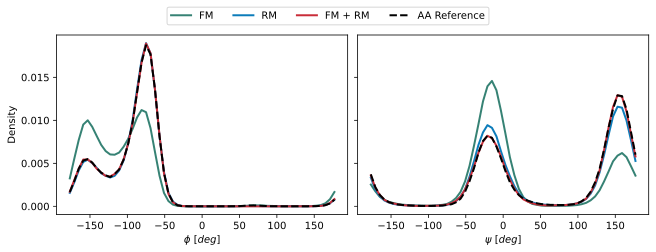

In [24]:
labels = ["FM", "RM", "FM + RM", "AA Reference"]

fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained", figsize=(9, 3), sharey=True)
ax1 = plot_1d_dihedral(ax1, [fm_phi, re_phi, fm_rm_phi, ref_phi], labels, xlabel="$\phi\ [deg]$")
ax2 = plot_1d_dihedral(ax2, [fm_psi, re_psi, fm_rm_psi, ref_psi], labels, xlabel="$\psi\ [deg]$", ylabel=False)
fig.legend(labels, ncols=len(labels), bbox_to_anchor=(0.5, 1.01), loc="lower center")

fig.savefig("../_data/output/alanine_dipeptide_1D_dihedral_angles.pdf", bbox_inches='tight')

Plotting the free energy surface of the backbone dihedral angles indicates similar results.
Both models can identify the regions of low free energy.
However, only the REM model correctly predicts the depth of these regions.

In [25]:
labels = ["AA Reference"]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, layout="constrained", figsize=(9, 3), sharey=True)
ax1, _ = plot_histogram_free_energy(ax1, ref_phi, ref_psi, kT, ylabel=True, title="AA Reference")
ax2, _ = plot_histogram_free_energy(ax2, fm_phi, fm_psi, kT, title="Force Matching")
ax3, _ = plot_histogram_free_energy(ax3, re_phi, re_psi, kT, title="Relative Entropy")
ax4, cax = plot_histogram_free_energy(ax4, fm_rm_phi, fm_rm_psi, kT, title="FM and RM")

cbar = fig.colorbar(cax)
cbar.set_label('Free Energy (kcal/mol)')

fig.savefig("../_data/output/alanine_dipeptide_free_energy_dihedral_angles.pdf", bbox_inches='tight')

## References


[^Thaler2022]: Stephan Thaler, Maximilian Stupp, Julija Zavadlav; *Deep coarse-grained potentials via relative entropy minimization*. J. Chem. Phys. 28 December 2022; 157 (24): 244103. <https://doi.org/10.1063/5.0124538>
[^Feig2008]: Feig, M. Is Alanine Dipeptide a Good Model for Representing the Torsional Preferences of Protein Backbones? _J. Chem. Theory Comput._ **2008**, _4_ (9), 1555–1564. [https://doi.org/10.1021/ct800153n](https://doi.org/10.1021/ct800153n).
[^DimeNet]: Gasteiger, J.; Giri, S.; Margraf, J. T.; Günnemann, S. _Fast and Uncertainty-Aware Directional Message Passing for Non-Equilibrium Molecules_. [http://arxiv.org/abs/2011.14115](http://arxiv.org/abs/2011.14115) (accessed 2023-06-29).
[^Duan2003]: Duan, Y.; Wu, C.; Chowdhury, S.; Lee, M. C.; Xiong, G.; Zhang, W.; Yang, R.; Cieplak, P.; Luo, R.; Lee, T.; Caldwell, J.; Wang, J.; Kollman, P. A Point‐charge Force Field for Molecular Mechanics Simulations of Proteins Based on Condensed‐phase Quantum Mechanical Calculations. _J Comput Chem_ **2003**, _24_ (16), 1999–2012. [https://doi.org/10.1002/jcc.10349](https://doi.org/10.1002/jcc.10349).
[^Tildesley2017]: Allen, M. P.; Tildesley, D. J. _Computer Simulation of Liquids_; Oxford University Press, 2017. [https://doi.org/10.1093/oso/9780198803195.001.0001](https://doi.org/10.1093/oso/9780198803195.001.0001).
[^McGibbon2015]: McGibbon, R. T.; Beauchamp, K. A.; Harrigan, M. P.; Klein, C.; Swails, J. M.; Hernández, C. X.; Schwantes, C. R.; Wang, L.-P.; Lane, T. J.; Pande, V. S. MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. _Biophys J_ **2015**, _109_ (8), 1528–1532. [https://doi.org/10.1016/j.bpj.2015.08.015](https://doi.org/10.1016/j.bpj.2015.08.015).